# Méthodes de sélection de variables par critères AIC|BIC

Ce notebook se concentre sur la sélection de modèles pour les modèles Lasso qui sont des modèles linéaires avec une pénalité L1 pour les problèmes de régression. Plusieurs stratégies peuvent être utilisées pour sélectionner la valeur du paramètre de régularisation : via une validation croisée ou en utilisant un critère d'information, à savoir AIC ou BIC.

Dans ce qui suit, nous explorerons ces différentes stratégies

ce notebook s'inspire de la source [Lasso model selection: AIC-BIC / cross-validation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html)

In [3]:
# manipulation de données
import pandas as pd
import numpy as np

# visualisation
import pylab as pl
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use('cyberpunk')

# modèles statistiques
from mord import LogisticAT
from sklearn.linear_model import LassoLarsIC

#Pour la régression Ridge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder

## Données

Chargement des données d'entraînement pré-traitées :

In [4]:
df_train = pd.read_csv("../../data/train.csv")
df_test = pd.read_csv("../../data/test.csv")

def get_train_test_sets(train_data, test_data):
    """Fonction qui récupère les dataframes train et test et retourne les vecteurs utiles pour la phase
    d'entrainement et test.

    Args:
        train_data (DataFrame): données d'entrainement pré-traitées
        test_data (DataFrame): données de test pré-traitées

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    
    X_train = train_data.drop(labels=["score"], axis=1).values
    y_train = train_data["score"].values

    X_test = test_data.drop(labels=["score"], axis=1).values
    y_test = test_data["score"].values
    

    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_sets(train_data=df_train, test_data=df_test)

In [5]:
liste_variables = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'salt_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'score']

df_train[liste_variables]

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,salt_100g,vitamin-c_100g,calcium_100g,iron_100g,score
0,1502.0,2.0,0.47,0.787663,0.000000,72.00,1.0,0.000000,1.0000,0.019264,0.230625,0.007938,2
1,788.0,7.1,2.20,0.198759,0.000563,20.00,2.3,2.700000,1.0000,0.028080,0.132071,0.005067,3
2,1234.0,31.3,8.50,0.020546,0.015637,18.75,1.1,1.500000,1.8000,0.031769,0.710842,0.007000,1
3,205.0,2.0,0.00,0.007910,0.000000,9.10,2.0,0.000000,0.1300,0.102756,0.015593,0.007031,4
4,508.0,5.0,0.50,0.058824,0.028896,11.00,4.0,0.000000,1.8000,0.037283,0.173588,0.007982,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34335,1983.0,21.0,4.70,0.576880,0.000000,25.80,28.0,3.600000,0.6000,0.000016,0.309437,0.004825,1
34336,1910.0,19.4,1.70,0.265686,0.000000,42.20,3.0,10.100000,1.9304,0.067192,0.309656,0.006700,2
34337,2386.0,36.0,22.00,0.097566,0.015394,56.00,55.0,1.333333,0.1900,0.053304,0.288824,0.006360,0
34338,2046.0,18.4,4.50,0.058257,0.000000,64.70,2.2,4.500000,3.8100,0.060823,0.567159,0.008957,1


## 1 Sélection Lasso par critère AIC | BIC

`LassoLarsIC` fournit un estimateur Lasso qui utilise le critère d'information d'Akaike (AIC) ou le critère d'information de Bayes (BIC) pour sélectionner la valeur optimale du paramètre de régularisation alpha.

C:\Users\jaure\AppData\Local\Temp\ipykernel_2332\2454080757.py:84: RuntimeWarning: divide by zero encountered in log10
  pl.plot(-np.log10(alphas_), criterion_, '--', color=color,


Text(0.5, 1.0, "Critère d'information model selection ")

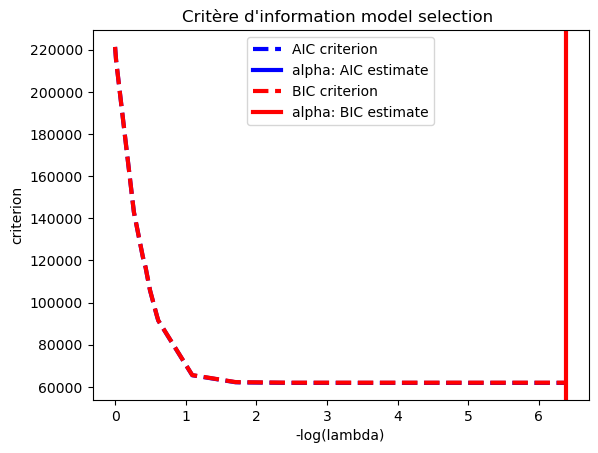

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from mord import LogisticAT


## On normalise les données
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

# Pour le BIC

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_train_, y_train)
alpha_bic_ = model_bic.alpha_


# Variables sélectionnées avec critère BIC
indices_variables_bic = np.where(model_bic.coef_ != 0)[0]
variables_bic = df_train.columns[indices_variables_bic]

# Entraîner le modèle de régression logistique ordinale avec critère BIC
model_ordinal_bic = LogisticAT(alpha=0)
model_ordinal_bic.fit(X_train[:, indices_variables_bic], y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_bic = model_ordinal_bic.predict(X_test[:, indices_variables_bic])

# Statistiques du BIC
r2_bic = r2_score(y_test, y_pred_bic)
mse_bic = mean_squared_error(y_test, y_pred_bic)
accuracy_bic = accuracy_score(y_test, y_pred_bic)


# Pour l'AIC

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train_, y_train)
alpha_aic_ = model_aic.alpha_

# Variables sélectionnées avec critère AIC
indices_variables_aic = np.where(model_aic.coef_ != 0)[0]
variables_aic = df_train.columns[indices_variables_aic]

# Entraîner le modèle de régression logistique ordinale avec critère AIC
model_ordinal_aic = LogisticAT(alpha=0)
model_ordinal_aic.fit(X_train[:, list(indices_variables_aic)], y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_aic = model_ordinal_aic.predict(X_test[:, list(indices_variables_aic)])

# Statistiques de l'AIC
r2_aic = r2_score(y_test, y_pred_aic)
mse_aic = mean_squared_error(y_test, y_pred_aic)
accuracy_aic = accuracy_score(y_test, y_pred_aic)

#Résultats des deux critères

results = pd.DataFrame({
    "Critère": ["AIC", "BIC"],
    "Variables Sélectionnées": [list(variables_aic), list(variables_bic)],
    "R²": [r2_aic, r2_bic],
    "MSE": [mse_aic, mse_bic],
    "Accuracy model ordinal": [accuracy_aic, accuracy_bic],
    "Alpha (AIC)": [alpha_aic_, np.nan],  # Notez que la valeur de l'alpha pour BIC est obtenue de la même manière
    "Alpha (BIC)": [np.nan, alpha_bic_]
})

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]


results.style.apply(highlight_min, subset=["Alpha (AIC)", "Alpha (BIC)"])




def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    pl.plot(-np.log10(alphas_), criterion_, '--', color=color,
            linewidth=3, label='%s criterion' % name)
    pl.axvline(-np.log10(alpha_), color=color,
              linewidth=3, label='alpha: %s estimate' % name)
    pl.xlabel('-log(lambda)')
    pl.ylabel('criterion')

pl.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
pl.legend()
pl.title("Critère d'information model selection ")


In [7]:
results

,Critère,Variables Sélectionnées,R²,MSE,Accuracy model ordinal,Alpha (AIC),Alpha (BIC)
0,AIC,"[energy_100g, fat_100g, saturated-fat_100g, tr...",0.838876,0.321142,0.714386,0.0,NaN
1,BIC,"[energy_100g, fat_100g, saturated-fat_100g, tr...",0.838350,0.322190,0.709493,NaN,4.105391e-07


### Variables sélectionnées

Les deux modèles donnent les mêmes variables

In [8]:
results["Variables Sélectionnées"][0]

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

In [9]:
model = LogisticAT(alpha=alpha_aic_)
model.fit(X_train[:, list(indices_variables_aic)], y_train)

import pickle

with open(f"../model/modele_ordinal.pkl", 'wb') as model_file:
    pickle.dump(model, model_file)


Re-load du modèle

In [10]:
#Afficher les coefficients du modèle
coefficients_aic = model_ordinal_aic.coef_
print("Coefficients du modèle optimal au sens de l'AIC:")
for variable, coefficient in zip(variables_aic, coefficients_aic):
    print(f"{variable}: {coefficient}")

Coefficients du modèle optimal au sens de l'AIC:
energy_100g: -0.0012431723396613948
fat_100g: -0.06175993283216424
saturated-fat_100g: -0.3949568389245772
trans-fat_100g: -1.1317263474419832
cholesterol_100g: -0.3392063577023831
carbohydrates_100g: -0.0011178576772549402
sugars_100g: -0.12927373998473415
fiber_100g: 0.491807419868037
proteins_100g: 0.06707516893793998
salt_100g: -1.657994888293285
sodium_100g: -0.652730337305263
vitamin-a_100g: 0.0030510701973274915
vitamin-c_100g: -0.0072851863701383236
calcium_100g: -0.5542955127564614
iron_100g: 1.0923504281413559


## Application du modèle

In [12]:
model = LogisticAT(alpha=alpha_aic_)
model.fit(X_train[:, list(indices_variables_aic)], y_train)

# Effectuez les prédictions sur les données de test
predictions = model.predict(X_test[:, indices_variables_aic])

# Calculez l'exactitude des prédictions
accuracy_ordinal = accuracy_score(y_test, predictions)

# Affichage de la précision du modèle
print("{:.2f}%".format(accuracy_ordinal * 100))

71.44%


In [14]:
X_test[:, indices_variables_aic][0]

array([3.77000000e+02, 1.30000000e+00, 1.00000000e-01, 7.50461255e-03,
       4.09409409e-03, 1.80000000e+01, 1.60000000e+01, 1.60000000e+00,
       0.00000000e+00, 1.61284333e-02, 1.25873016e-01, 3.60745098e-03])

# Régression logistique ordinale pénalisé par le critère L1 (Ridge)

On va utiliser la régression régularisée Ridge et on va l'adapter à notre problème de régression ordinale. Pour se faire, on va faire suivre la régression Ridge d'une transformation ordonnale des prédictions.

In [11]:
X = X_train[:, list(indices_variables_aic)]
X_t = X_test[:, list(indices_variables_aic)]
    

# On crée un objet OrdinalEncoder pour encoder les catégories ord
ordinal_encoder = OrdinalEncoder()

# On transforme les catégories ordinales de la variable cible pour le modèle Ridge
y_encoded = ordinal_encoder.fit_transform(y_train.reshape(-1, 1))

# On Crée un modèle de régression Ridge
alpha = 1.0  # Paramètre de régularisation
ridge = Ridge(alpha=1.0)

# Entraînement du modèle Ridge sur nos données de train
ridge.fit(X, y_encoded)

# Prédictions sur les données test
predictions = ridge.predict(X_t)

# On transforme les prédictions Ridge en catégories ordinales pour retrouver nos scores
predictions_ordinales = ordinal_encoder.inverse_transform(predictions.reshape(-1, 1))

# Calcul de l'erreur de classification
erreur_classification = 1 - accuracy_score(y_test, predictions_ordinales)
print("Erreur de classification : {:.2f}%".format(erreur_classification * 100))

# Coefficients du modèle Ridge
coefficients = ridge.coef_
intercept = ridge.intercept_
print("Coefficients du modèle Ridge :")
print("Coefficients :", coefficients)
print("Intercept :", intercept)

0.35653553590070897


# Probalilités prédites pour un test du modèle

In [12]:
# Je charge le modèle...

with open('../model/modele_ordinal.pkl', 'rb') as model_file:
    model_ordinal = pickle.load(model_file)
def test_model(model, aliment):
    probas =  model.predict_proba(aliment)
    

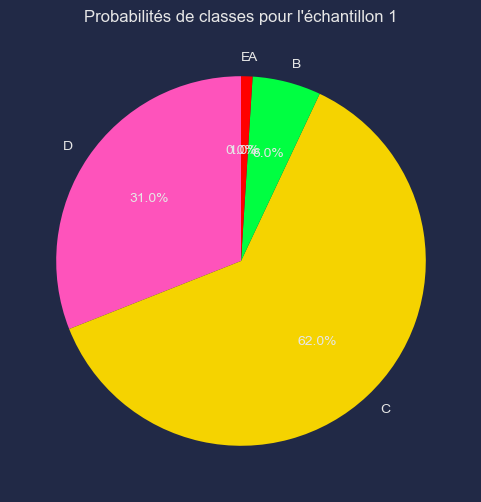

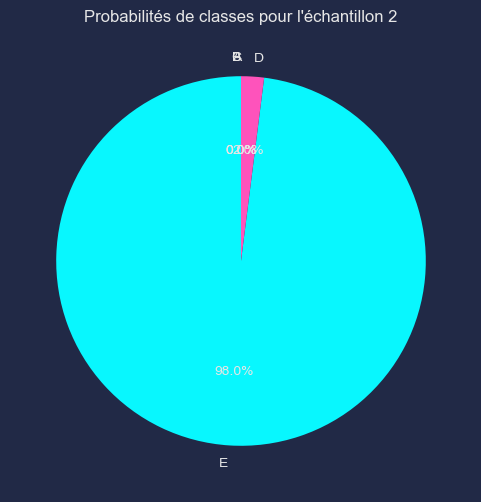

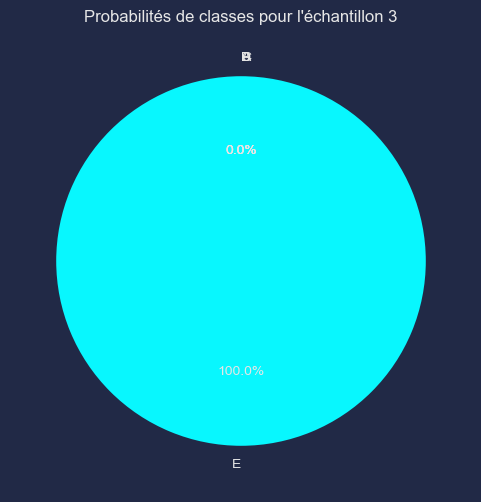

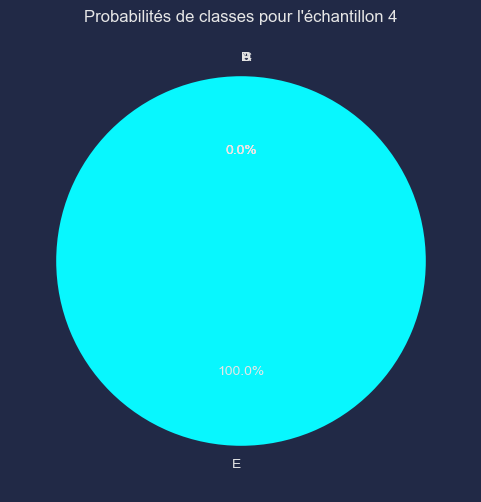

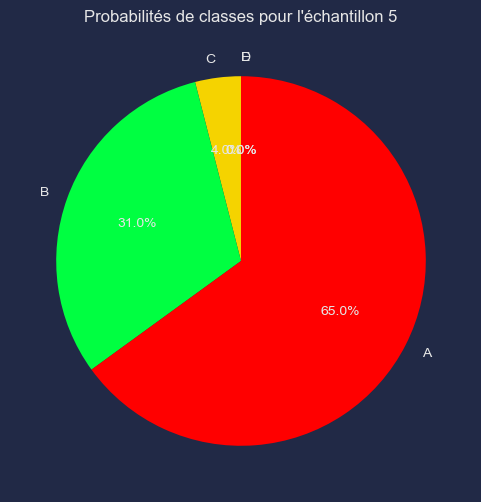

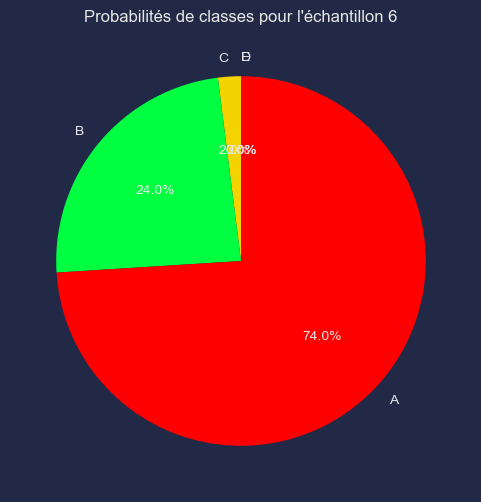

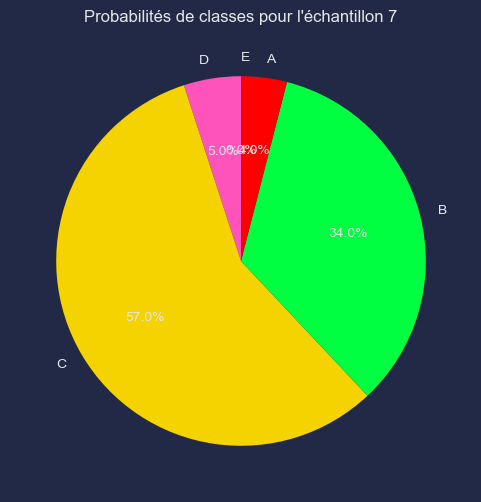

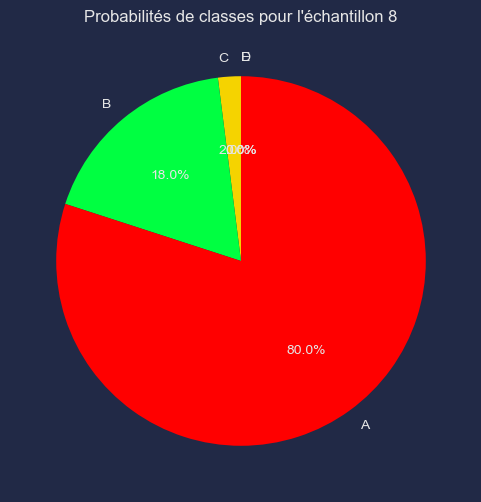

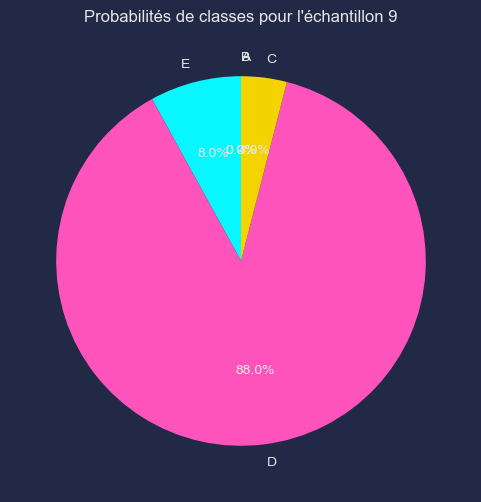

In [37]:
import matplotlib.pyplot as plt

def score_probas(model, X):
    """Fonction pour obtenir les probabilités de classe pour un échantillon de test

    Args:
        model : modèle utilisé
        X (np.array): matrice du/des échantillon(s)

    Returns:
       probas : vecteur des 5 probas de classes rangées dans cet ordre : [E, D, C, B, A] 
    """
    probas = model.predict_proba(X)
    probas = np.round(probas, decimals=2) # j'arrondis à 2 décimales sinon on a 6 chiffres après la virgule...
    return probas

# On récupères les labels des scores :
scores = pd.read_csv("../../data/nutri_code.csv")
scores_dict = {scores['Lettre'][i].upper() : scores['Valeur'][i] for i in range(scores.shape[0])}
labels_scores = list(scores_dict.keys())

def plot_diagramme_probas(probas):
    # Affiche un diagramme circulaire des probabilités sur les scores
    num_samples, num_classes = probas.shape # numsamples c'est au cas où plusieurs aliments son testés en même temps, sinon il fait juste pour un aliment
    for i in range(num_samples):
        plt.figure(figsize=(6, 6))
        plt.pie(probas[i], labels=labels_scores, autopct='%1.1f%%', startangle=90)
        plt.title('Probabilités de classes pour l\'échantillon {}'.format(i + 1))
        plt.show()

# Exemple d'utilisation
# 1 faire la prédiction et onbtenir les probas
probabilities = score_probas(model = model_ordinal, X = X_test[:, indices_variables_aic][1:10]) # je teste sur 10 exemples

# 2 afficher en terme de diagramme circulaire
plot_diagramme_probas(probabilities)



